### Import Libraries

In [43]:
import re
import nltk
import string
import re
import os
import time
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn.feature_extraction.text as ft
import seaborn as sns

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn import metrics
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

### Loading Files

In [10]:
# Train source files
train = pd.read_csv('dataset/train.csv')
train = train[['comment_text', 'toxic']]

#Test source files
test = pd.read_csv('dataset/test.csv')
test_labels = pd.read_csv('dataset/test_labels.csv')
test = test.join(test_labels, lsuffix='id', rsuffix='id', how='inner')[['comment_text', 'toxic']]
test.rename(columns={'content' : 'comment_text'}, inplace=True)
test = test[test['toxic']!=-1]

# Validation source files
validation = pd.read_csv('dataset/validation.csv')
validation = validation[['comment_text', 'toxic']]

In [13]:
# Joining train and validation to single data source
corpus_data = pd.concat([train, validation])
corpus_data.shape

(231549, 2)

In [38]:
def print_data_statistics(dataframe, name):
    # define color codes for console output
    color = { "PURPLE": '\033[95m',"CYAN": '\033[96m',"DARKCYAN": '\033[36m',"BLUE": '\033[94m',"GREEN": '\033[92m',
   "YELLOW": '\033[93m',"RED": '\033[91m',"BOLD": '\033[1m',"UNDERLINE": '\033[4m',"END": '\033[0m'}
    print("---------------------"+ color['BOLD'] + name + color['END']+"---------------------")
    
    # print count and percentage of each class
    print("Data Distribution by count")
    print(dataframe.toxic.value_counts())
    print("\nData Distribution by percentage")
    print((dataframe.toxic.value_counts()/dataframe.shape[0]).round(3))
    
    # plot the class distribution
    dataframe['toxic'].value_counts().plot(kind='bar')
    plt.title(f"{name} dataset distribution")
    plt.show()

---------------------Train---------------------
Data Distribution by count
0    208460
1     22613
Name: toxic, dtype: int64

Data Distribution by percentage
0    0.902
1    0.098
Name: toxic, dtype: float64


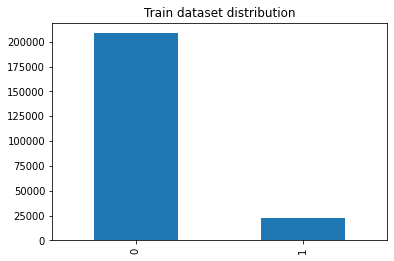

---------------------Test---------------------
Data Distribution by count
0    44591
1    12645
Name: toxic, dtype: int64

Data Distribution by percentage
0    0.779
1    0.221
Name: toxic, dtype: float64


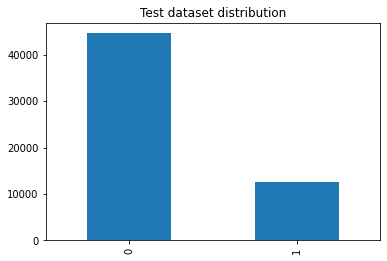

In [39]:
print_data_statistics(corpus_data, 'Train')
print_data_statistics(test, 'Test')

## Preprocess Data

In [2]:
def preprocess_text(text):
    # Remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize text into words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    # Join words back into a single string
    preprocessed_text = ' '.join(words)
    
    # Remove extra whitespaces
    preprocessed_text = re.sub(r'\s+', ' ', preprocessed_text).strip()
    
    return preprocessed_text

In [3]:
# Checking for stored preprocessed files
if os.path.exists('cleaned_corpus.csv'):
    corpus_data = pd.read_csv('cleaned_corpus.csv')
else:
    corpus_data['comment_text'] = corpus_data['comment_text'].apply(preprocess_text)
    corpus_data.to_csv('cleaned_corpus.csv', index=False)
    
if os.path.exists('cleaned_corpus_test.csv'):
    test = pd.read_csv('cleaned_corpus_test.csv')
else:
    test['comment_text'] = test['comment_text'].apply(preprocess_text)
    test.to_csv('cleaned_corpus_test.csv', index=False)

# Removing na values on text
corpus_data = corpus_data[corpus_data['comment_text'].notna()]
test = test[test['comment_text'].notna()]

In [5]:
stop_words = set(stopwords.words('english'))
stopwords = set(STOPWORDS)

In [7]:
X = corpus_data['comment_text']
y = corpus_data['toxic']

# Tfidf text transformation
vectorizer = ft.TfidfVectorizer(stop_words=list(stopwords))

# Train Test Split
X_train,X_val,y_train,y_val = train_test_split(vectorizer.fit_transform(X),y,
                                               test_size=0.3,random_state=42, stratify=y)

/Users/mariaanson/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


In [8]:
# Tfidf text transformation
X_test = vectorizer.transform(test['comment_text'])
y_test = test['toxic']

In [23]:
def plot_confusion_matrix(y_true, y_pred, classes):
    
    # Create confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=classes, yticklabels=classes, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

## KNN

In [10]:
# Initializing k values and f1 scores list
k_values = []
f1_scores = []
# Running odd k numbers from 1 to 30 
for k in range(1,30,2):
    start_time = time.time()
    
    # Adding the current k value
    k_values.append(k)
    
    # Fitting the knn model
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Storing the validation f1 score metric
    y_val_pred = knn.predict(X_val)
    f1_scores.append(metrics.f1_score(y_val,y_val_pred))
    
    end_time = time.time() 
    print(f"Model with {k} neighbors is done in {(end_time - start_time)/60} mins")

Model with 1 neighbors is done in 8.823054385185241 mins
Model with 3 neighbors is done in 8.826701466242472 mins
Model with 5 neighbors is done in 9.057123084863028 mins
Model with 7 neighbors is done in 8.882700085639954 mins
Model with 9 neighbors is done in 8.667244132359823 mins
Model with 11 neighbors is done in 8.639225212732951 mins
Model with 13 neighbors is done in 8.62796364625295 mins
Model with 15 neighbors is done in 8.704751404126485 mins
Model with 17 neighbors is done in 8.81043203274409 mins
Model with 19 neighbors is done in 8.827569731076558 mins
Model with 21 neighbors is done in 8.624505750338237 mins
Model with 23 neighbors is done in 8.625908847649892 mins
Model with 25 neighbors is done in 8.627513416608174 mins
Model with 27 neighbors is done in 8.60169734954834 mins
Model with 29 neighbors is done in 8.625305004914601 mins


Text(0.5, 1.0, 'Elbow curve')

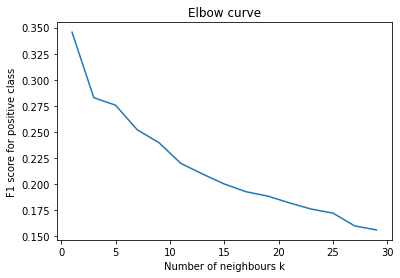

In [14]:
# Plotting the elbow curve
plt.plot(k_values, f1_scores)
plt.xlabel("Number of neighbours k")
plt.ylabel("F1 score for positive class") 
plt.title("Elbow curve")

As we see using the elbow plot, there isn't a clear elbow and the f1 score of the model keeps decreasing as the number of k increases.

Thus we select the model with k value as 1 as the best model.

In [35]:
best_knn = KNeighborsClassifier(n_neighbors=1)
best_knn.fit(X_train, y_train)
print(metrics.classification_report(y_test, best_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87     44591
           1       0.40      0.01      0.02     12645

    accuracy                           0.78     57236
   macro avg       0.59      0.50      0.45     57236
weighted avg       0.70      0.78      0.69     57236



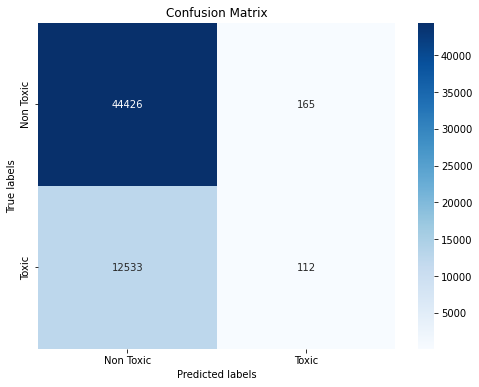

In [36]:
plot_confusion_matrix(y_test, best_knn.predict(X_test), ['Non Toxic', 'Toxic'])

The model is struggling to find the true labels, as noted by the confusion matrix above. The reason could be because of the data imbalance problem.

## Random Forest

In [14]:
# Setting the parameters to explore
params_grid = {'n_estimators': list(np.linspace(1,100,15, dtype=int)),
              'max_depth': [None, 2, 5, 10, 15],
              'max_features': ['sqrt', 'log2', None],
              'min_samples_split': list(np.linspace(1,20,6,dtype=int)),
              'min_samples_leaf': list(np.linspace(1,20,5,dtype=int)),
              'class_weight' : ["balanced", "balanced_subsample", None]}

rf = RandomForestClassifier()

# Running a random search with 20 possibilities
random_search = RandomizedSearchCV(estimator=rf, scoring='f1_micro',
                                   param_distributions=params_grid,
                                   n_iter=20,
                                   cv=5, verbose=5)

# Training
random_search.fit(vectorizer.fit_transform(corpus_data['comment_text']), corpus_data['toxic'])

print(random_search.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=1, n_estimators=100;, score=0.902 total time= 1.2min
[CV 2/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=1, n_estimators=100;, score=0.902 total time= 1.2min
[CV 3/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=1, n_estimators=100;, score=0.902 total time= 1.2min
[CV 4/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=1, n_estimators=100;, score=0.902 total time= 1.2min
[CV 5/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=15, min_samples_split=1, n_estimators=100;, score=0.902 total time=  56.9s
[CV 1/5] END class_weight=None, max_depth=15, max_features=sqrt, min_samples_leaf=5, min_samples_split=20, n_estimators=64;, score=0.902 total time=  46.

[CV 3/5] END class_weight=None, max_depth=2, max_features=log2, min_samples_leaf=20, min_samples_split=16, n_estimators=71;, score=0.902 total time=   1.6s
[CV 4/5] END class_weight=None, max_depth=2, max_features=log2, min_samples_leaf=20, min_samples_split=16, n_estimators=71;, score=0.902 total time=   1.6s
[CV 5/5] END class_weight=None, max_depth=2, max_features=log2, min_samples_leaf=20, min_samples_split=16, n_estimators=71;, score=0.902 total time=   1.6s
[CV 1/5] END class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=20, n_estimators=36;, score=0.929 total time=14.6min
[CV 2/5] END class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=20, n_estimators=36;, score=0.929 total time=14.6min
[CV 3/5] END class_weight=balanced, max_depth=5, max_features=None, min_samples_leaf=10, min_samples_split=20, n_estimators=36;, score=0.932 total time=14.6min
[CV 4/5] END class_weight=balanced, max_depth=5, max

In [15]:
print("The best parameters are: ", random_search.best_params_) #print the best parameters
print("The score of the best parameters is: ", random_search.best_score_)  #print the best score

The best parameters are:  {'n_estimators': 36, 'min_samples_split': 16, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': None}
The score of the best parameters is:  0.9400016060642875


In [18]:
print(metrics.classification_report(y_test, random_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     44591
           1       0.88      0.11      0.20     12645

    accuracy                           0.80     57236
   macro avg       0.84      0.55      0.54     57236
weighted avg       0.82      0.80      0.73     57236



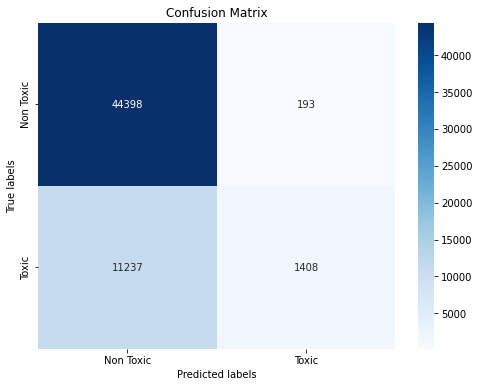

None


In [24]:
plot_confusion_matrix(y_test, random_search.predict(X_test), ['Non Toxic', 'Toxic'])

In [17]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,69.034909,6.275943,0.391742,0.006905,100,1,15,sqrt,15,None,"{'n_estimators': 100, 'min_samples_split': 1, ...",0.902131,0.902131,0.902131,0.902151,0.902151,0.902139,0.000010,8
1,44.899437,4.185761,0.274110,0.004601,64,20,5,sqrt,15,None,"{'n_estimators': 64, 'min_samples_split': 20, ...",0.902131,0.902131,0.902131,0.902151,0.902151,0.902139,0.000010,8
2,212.004293,25.458018,0.740933,0.031612,43,4,20,sqrt,None,balanced,"{'n_estimators': 43, 'min_samples_split': 4, '...",0.873656,0.864330,0.871557,0.837344,0.725192,0.834416,0.056129,16
3,1.433649,0.032799,0.216712,0.005960,64,16,5,log2,2,None,"{'n_estimators': 64, 'min_samples_split': 16, ...",0.902131,0.902131,0.902131,0.902151,0.902151,0.902139,0.000010,8
4,766.150870,71.487787,3.456285,0.399375,36,16,1,sqrt,None,None,"{'n_estimators': 36, 'min_samples_split': 16, ...",0.942594,0.942767,0.943525,0.943978,0.927143,0.940002,0.006449,1
5,4081.036197,175.996257,1.149285,0.108399,50,8,15,None,None,balanced,"{'n_estimators': 50, 'min_samples_split': 8, '...",0.935973,0.936709,0.933571,0.900982,0.858658,0.913179,0.030366,6
6,415.589675,43.139188,0.107969,0.004760,15,12,20,None,15,balanced,"{'n_estimators': 15, 'min_samples_split': 12, ...",0.938829,0.939046,0.939435,0.926429,0.905397,0.929827,0.013166,4
7,1.599126,0.040505,0.237864,0.008536,71,16,1,log2,2,None,"{'n_estimators': 71, 'min_samples_split': 16, ...",0.902131,0.902131,0.902131,0.902151,0.902151,0.902139,0.000010,8
8,43.391550,4.217996,0.268888,0.009857,64,8,20,sqrt,15,None,"{'n_estimators': 64, 'min_samples_split': 8, '...",0.902131,0.902131,0.902131,0.902151,0.902151,0.902139,0.000010,8
9,0.717094,0.017830,0.125158,0.005837,29,1,20,log2,5,balanced,"{'n_estimators': 29, 'min_samples_split': 1, '...",0.149670,0.900725,0.120913,0.246938,0.112455,0.306140,0.301112,19


## XGBoost

In [26]:
# Define the search space
param_grid = { 
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    "max_depth": range(3,21,3),
    "gamma": [i/10.0 for i in range(0,5)],
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100],
    "scale_pos_weight": [1, len(y_train)/y_train.sum()]
    }

In [27]:
xg = XGBClassifier()

# Running a random search with 20 iterations
xg_search = RandomizedSearchCV(estimator=xg, scoring='f1_micro',
                                   param_distributions=param_grid,
                                   n_iter=20,
                                   cv=5, verbose=5)

xg_search.fit(vectorizer.fit_transform(corpus_data['comment_text']), corpus_data['toxic'])

print(xg_search.best_estimator_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.0001, max_depth=12, reg_alpha=10, reg_lambda=100, scale_pos_weight=10.218649314549245;, score=0.701 total time=  18.4s
[CV 2/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.0001, max_depth=12, reg_alpha=10, reg_lambda=100, scale_pos_weight=10.218649314549245;, score=0.700 total time=  15.9s
[CV 3/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.0001, max_depth=12, reg_alpha=10, reg_lambda=100, scale_pos_weight=10.218649314549245;, score=0.698 total time=  15.9s
[CV 4/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.0001, max_depth=12, reg_alpha=10, reg_lambda=100, scale_pos_weight=10.218649314549245;, score=0.660 total time=  15.8s
[CV 5/5] END colsample_bytree=0.3, gamma=0.3, learning_rate=0.0001, max_depth=12, reg_alpha=10, reg_lambda=100, scale_pos_weight=10.218649314549245;, score=0.554 total time=  16.1s
[CV 1/5] END colsample_bytree=0.8

[CV 4/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=15, reg_alpha=10, reg_lambda=1e-05, scale_pos_weight=1;, score=0.942 total time=  15.3s
[CV 5/5] END colsample_bytree=0.3, gamma=0.4, learning_rate=1, max_depth=15, reg_alpha=10, reg_lambda=1e-05, scale_pos_weight=1;, score=0.914 total time=  15.2s
[CV 1/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.001, max_depth=3, reg_alpha=10, reg_lambda=1, scale_pos_weight=1;, score=0.928 total time=  10.0s
[CV 2/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.001, max_depth=3, reg_alpha=10, reg_lambda=1, scale_pos_weight=1;, score=0.927 total time=   9.8s
[CV 3/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.001, max_depth=3, reg_alpha=10, reg_lambda=1, scale_pos_weight=1;, score=0.923 total time=   9.9s
[CV 4/5] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.001, max_depth=3, reg_alpha=10, reg_lambda=1, scale_pos_weight=1;, score=0.919 total time=  10.0s
[CV 5/5] END colsample_bytree=0.9, gam

[CV 3/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=3, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=10.218649314549245;, score=0.566 total time=   7.3s
[CV 4/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=3, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=10.218649314549245;, score=0.529 total time=   7.2s
[CV 5/5] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.01, max_depth=3, reg_alpha=0.01, reg_lambda=0.1, scale_pos_weight=10.218649314549245;, score=0.903 total time=   7.2s
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1, max_bin=None,
              max_cat_threshold=None, max_c

In [28]:
print("The best parameters are: ", xg_search.best_params_) #print the best parameters
print("The score of the best parameters is: ", xg_search.best_score_)  #print the best score

The best parameters are:  {'scale_pos_weight': 1, 'reg_lambda': 1e-05, 'reg_alpha': 10, 'max_depth': 15, 'learning_rate': 1, 'gamma': 0.4, 'colsample_bytree': 0.3}
The score of the best parameters is:  0.9417715268343578


In [31]:
print(metrics.classification_report(y_test, xg_search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88     44591
           1       0.61      0.18      0.28     12645

    accuracy                           0.79     57236
   macro avg       0.71      0.57      0.58     57236
weighted avg       0.76      0.79      0.75     57236



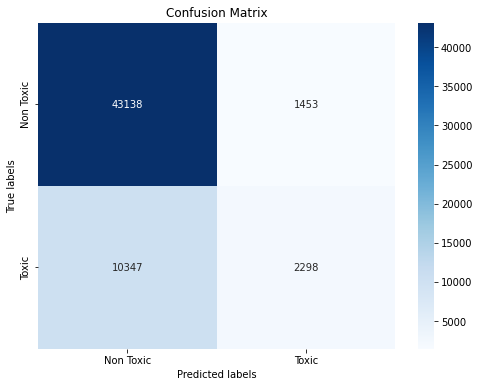

In [32]:
plot_confusion_matrix(y_test, xg_search.predict(X_test), ['Non Toxic', 'Toxic'])